**Авторы:** Таряник Антон (467677, J3111), Дубовик Никита (465809, J3110)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import math
import matplotlib.pyplot as plt
import random
from matplotlib.figure import Figure
from typing import Union

In [ ]:
class Matrix:
    def __init__(self, data: list[list[int | float]]) -> None:
        if not isinstance(data, list):
            raise TypeError("Данные должны быть списком из списков")

        if not data:
            self.data: list[list[int | float]] = []
            self.rows: int = 0
            self.cols: int = 0
            return

        row_lengths = {len(row) for row in data}
        if len(row_lengths) > 1:
            raise ValueError("Все строки должны иметь одинаковую длину")

        if any(not isinstance(elem, (int, float)) for row in data for elem in row):
            raise ValueError("Все элементы должны быть числами")

        self.data: list[list[int | float]] = data
        self.rows: int = len(data)
        self.cols: int = len(data[0]) if data else 0

    def __add__(self, other: 'Matrix') -> 'Matrix':
        if not isinstance(other, Matrix):
            raise TypeError("Поддерживается сложение только матрицы с матрицей")
        if self.rows != other.rows or self.cols != other.cols:
            raise ValueError("Матрицы должны иметь одинаковые размеры")
        return Matrix([[self.data[i][j] + other.data[i][j] for j in range(self.cols)] for i in range(self.rows)])

    def __sub__(self, other: 'Matrix') -> 'Matrix':
        if not isinstance(other, Matrix):
            raise TypeError("Поддерживается вычитание только матрицы из матрицы")
        if self.rows != other.rows or self.cols != other.cols:
            raise ValueError("Матрицы должны иметь одинаковые размеры")
        return Matrix([[self.data[i][j] - other.data[i][j] for j in range(self.cols)] for i in range(self.rows)])

    def __mul__(self, other: Union[int, float, 'Matrix']) -> 'Matrix':
        if isinstance(other, (int, float)):
            return Matrix([[elem * other for elem in row] for row in self.data])
        elif isinstance(other, Matrix):
            if self.rows != other.rows or self.cols != other.cols:
                raise ValueError("Матрицы должны быть одного размера")
            return Matrix([[self.data[i][j] * other.data[i][j] for j in range(self.cols)] for i in range(self.rows)])
        else:
            raise TypeError("Неподдерживаемый тип умножения")


    def __matmul__(self, other: 'Matrix') -> 'Matrix':
        if not isinstance(other, Matrix):
            raise TypeError("Матричное умножение только с матрицей")
        if self.cols != other.rows:
            raise ValueError(f"Матрицы должны быть одного размера, cols матрицы A: {self.cols}, rows матрицы B: {other.rows}")
        return Matrix([[sum(a * b for a, b in zip(row, col)) for col in zip(*other.data)] for row in self.data])

    def __rmul__(self, other: int | float) -> 'Matrix':
        return self.__mul__(other)

    def __iadd__(self, other: 'Matrix') -> 'Matrix':
        if not isinstance(other, Matrix):
            raise TypeError("Поддерживается сложение только матрицы с матрицей")
        if self.rows != other.rows or self.cols != other.cols:
            raise ValueError("Матрицы должны иметь одинаковые размеры")
        for i in range(self.rows):
            for j in range(self.cols):
                self.data[i][j] += other.data[i][j]
        return self

    def __isub__(self, other: 'Matrix') -> 'Matrix':
        if not isinstance(other, Matrix):
            raise TypeError("Поддерживается вычитание только матрицы из матрицы")
        if self.rows != other.rows or self.cols != other.cols:
            raise ValueError("Матрицы должны иметь одинаковые размеры")
        for i in range(self.rows):
            for j in range(self.cols):
                self.data[i][j] -= other.data[i][j]
        return self

    def __eq__(self, other: object) -> bool:
        if not isinstance(other, Matrix):
            return False
        return self.data == other.data

    def __repr__(self) -> str:
        return f"Matrix({self.data})"

    def __str__(self) -> str:
        return '\n'.join([' '.join(map(str, row)) for row in self.data])



    @property
    def is_square(self) -> bool:
        return self.rows == self.cols

    def transpose(self) -> 'Matrix':
        """
        Выход:
        x_transposed: Транспонированная матрица
        """
        return Matrix(list(map(lambda row: list(row), zip(*self.data))))

    def calculate_determinant(self) -> int | float:
        """
        Выход:
        determinant: Определитель матрицы
        Raises:
        ValueError: Если матрица не квадратная или пуста
        """
        if not self.is_square:
            raise ValueError("Определитель определен только для квадратных матриц")
        elif self.rows == 0:
            raise ValueError("Пустая матрица не имеет определителя")
        elif self.rows == 1:
            return self.data[0][0]
        elif self.rows == 2:
            return self.data[0][0] * self.data[1][1] - self.data[0][1] * self.data[1][0]

        determinant: int | float = 0
        for j in range(self.cols):
            element = self.data[0][j]
            minor = Matrix([row[:j] + row[j + 1:] for row in self.data[1:]])
            determinant_minor = minor.calculate_determinant()
            sign = (-1) ** j
            determinant += element * sign * determinant_minor
        return determinant

    def round_zero(self, epsilon: float=1e-10):
        """Обнуляет элементы, абсолютное значение которых меньше epsilon."""
        for i in range(self.rows):
            for j in range(self.cols):
                if abs(self.data[i][j]) < epsilon:
                    self.data[i][j] = 0.0
        return self

    def copy(self):
      """Возвращает копию матрицы"""
      return Matrix(self.data.copy())


    def submatrix(self, row_start: int, col_start: int, row_size: int, col_size: int):
        """Возвращает подматрицу размером row_size x col_size, начиная с (row_start, col_start)."""
        return Matrix([
            [self.data[i][j] for j in range(col_start, col_start + col_size)]
            for i in range(row_start, row_start + row_size)
        ])

    def set_submatrix(self, row_start: int, col_start: int, submatrix: 'Matrix'):
        """Возвращает новую матрицу с изменённой подматрицей"""
        new_data = [row.copy() for row in self.data]
        for i in range(submatrix.rows):
            for j in range(submatrix.cols):
                new_data[row_start + i][col_start + j] = submatrix.data[i][j]
        return Matrix(new_data)

    @staticmethod
    def identity(rows, cols=None):
        """Создает единичную матрицу или вектор-столбец с единицей на позиции (i,i)."""
        cols = cols or rows
        return Matrix([[1.0 if i == j else 0.0 for j in range(cols)] for i in range(rows)])




    def norm(self):
      """Вычисляет евклидову норму вектора (для вектора-столбца)."""
      return sum(x**2 for row in self.data for x in row)**0.5


    def trace(self) -> int | float:
        """
        Выход:
        trace: След матрицы
        Raises:
        ValueError: Если матрица не квадратная
        """
        if not self.is_square:
            raise ValueError("След определён только для квадратных матриц")
        return sum(self.data[i][i] for i in range(self.rows))

    # для тестов
    def is_close(self, other: 'Matrix', tol: float = 1e-9) -> bool:
        if self.rows != other.rows or self.cols != other.cols:
            return False
        for i in range(self.rows):
            for j in range(self.cols):
                if abs(self.data[i][j] - other.data[i][j]) > tol:
                    return False
        return True


In [ ]:
def generate_standard_basis(n: int) -> Matrix:
  """Возвращает матрицу стандартного базиса размерности nxn"""
  basis = []
  for i in range(n):
    e = [0] * n
    e[i] = 1
    basis.append(e)
  return Matrix(basis)

Метод бисекции:

In [ ]:
def householder_reflection(x: Matrix) -> tuple[Matrix, float]:
    """
    Вычисляет вектор и коэффициент для преобразования Хаусхолдера, отражающего вектор x на вектор с одной ненулевой компонентой.

    Формат входа:
    x: Matrix - вектор-столбец размерности m×1

    Формат выхода:
    (v, beta): (Matrix, float) - вектор отражения Хаусхолдера и коэффициент.
                  Если входной вектор нулевой или пустой, возвращает (None, 0.0)

    Теоретическая часть:
    Преобразование Хаусхолдера H = I - beta*v*v^T отражает вектор x относительно гиперплоскости,
    обнуляя все компоненты кроме первой. Алгоритм:
    1. Вычисляется норма вектора alpha = ||x||
    2. Знак sign выбирается противоположным x[0] для минимизации ошибок округления
    3. Вектор отражения v = x + sign*alpha*e1 (e1 - первый базисный вектор)
    4. Коэффициент beta = 2/(v^T*v) обеспечивает ортогональность преобразования
    """
    eps = 1e-15
    m = x.rows
    if m == 0:
        return None, 0.0
    alpha = x.norm()
    if alpha < eps:
        return None, 0.0

    sign = 1 if x.data[0][0] >= 0 else -1
    v_data = x.data.copy()
    v_data[0][0] += sign * alpha
    v = Matrix(v_data)
    beta = 2.0 / ((v.transpose() @ v).data[0][0])
    return v, beta

def triangularize(A: Matrix) -> Matrix:
    """
    Приводит квадратную матрицу A к верхней форме Хессенберга с использованием преобразований Хаусхолдера.

    Формат входа:
    A: Matrix - квадратная матрица размерности n×n

    Формат выхода:
    Matrix - матрица в верхней форме Хессенберга.
             Модифицирует исходную матрицу, сохраняя подобие.

    Теоретическая часть:
    Алгоритм последовательно обнуляет элементы ниже первой поддиагонали с помощью преобразований Хаусхолдера:
    1. Для каждого столбца k (0 ≤ k < n-2):
       a. Выделяется подвектор x в столбце k ниже диагонали
       b. Строится преобразование Хаусхолдера для вектора x
       c. Применяется преобразование слева к подматрице A[k+1:, k:] для обнуления элементов
       d. Применяется преобразование справа к подматрице A[:, k+1:] для сохранения подобия матрицы

    Свойства:
    - Сохраняет собственные значения матрицы (подобное преобразование)
    - Сложность O(n^3) операций
    - Численно устойчив благодаря использованию ортогональных преобразований
    """
    n = A.rows
    for k in range(n - 2):
        # Берутся элементы столбца k ниже диагонали (k+1 до n-1)
        x = A.submatrix(row_start=k+1, col_start=k, row_size=n-k-1, col_size=1)

        if x.rows == 0:
            continue
        v, beta = householder_reflection(x)
        if v is None or beta < 1e-10:
            continue

        # Применяем отражение слева к подматрице A[k+1:, k:]
        sub_left = A.submatrix(row_start=k+1, col_start=k, row_size=n-k-1, col_size=n-k)
        vT = v.transpose()
        update_left = (v @ (vT @ sub_left)) * beta

        for i in range(k+1, n):
            for j in range(k, n):
                A.data[i][j] -= update_left.data[i - (k+1)][j - k]

        # Применяем отражение справа
        sub_right = A.submatrix(row_start=0, col_start=k+1, row_size=n, col_size=n-k-1)
        temp = sub_right @ v
        update_right = (temp @ vT) * beta

        for i in range(n):
            for j in range(k+1, n):
                A.data[i][j] -= update_right.data[i][j - (k+1)]
    A.round_zero()
    return A

In [ ]:
def sturm_sequence_count(T: Matrix, sigma: float) -> int:
    """
    Возвращает количество перемен знака в последовательности Штурма для заданного sigma.

    Формат входа:
    T: Matrix - трехдиагональная матрица размерности n×n
    sigma: float - значение для сравнения

    Формат выхода:
    int - количество собственных значений матрицы T, меньших sigma

    Теоретическая часть:
    Последовательность Штурма {p_0, p_1, ..., p_n} строится рекуррентно:
    p_0 = 1
    p_1 = T[0][0] - sigma
    p_i = (T[i][i] - sigma) * p_{i-1} - (T[i-1][i]^2) * p_{i-2}

    Количество перемен знака определяется по правилу:
    - Знак считается измененным, если p_i * p_{i-1} < 0
    - Нулевые значения игнорируются в последовательности

    Свойства:
    - Число перемен знака равно количеству собственных значений < sigma (теорема Штурма)
    """
    n = T.rows
    p_prev = 1.0
    p_curr = T.data[0][0] - sigma
    sign_changes = 0

    if p_prev * p_curr < 0:
        sign_changes += 1

    for i in range(1, n):
        p_next = (T.data[i][i] - sigma) * p_curr - (T.data[i-1][i] ** 2) * p_prev
        if p_curr * p_next < 0:
            sign_changes += 1
        p_prev, p_curr = p_curr, p_next

    return sign_changes

In [ ]:
def bisection(T: Matrix, low: float, high: float, epsilon: float=1e-6, eigenvalues: list[float]=None) -> list[float]:
    """
    Находит собственные значения трехдиагональной матрицы T в интервале [low, high] методом бисекции.

    Формат входа:
    T: Matrix - симметричная трехдиагональная матрица
    low: float - левая граница интервала поиска
    high: float - правая граница интервала поиска
    epsilon: float - точность определения (по умолчанию 1e-6)
    eigenvalues: list[float] - список собственных значений (нужо для рекурсии)
    Формат выхода:
    list[float] - список собственных значений в [low, high]

    Теоретическая часть:
    Алгоритм бисекции для локализации собственных значений:
    1. Использует теорему Штурма для подсчета числа собственных значений в интервале
    2. Рекурсивно делит интервал, пока его ширина не станет меньше epsilon
    3. Для узких интервалов добавляет среднюю точку как приближение собственного значения
    """
    if eigenvalues is None:
        eigenvalues = []

    count_high = sturm_sequence_count(T, high)
    count_low = sturm_sequence_count(T, low)
    num_eigenvalues = count_high - count_low

    if num_eigenvalues == 0:
        return eigenvalues

    if high - low < epsilon:
        mid = (low + high) / 2
        eigenvalues.extend([mid] * num_eigenvalues)
        return eigenvalues

    mid = (low + high) / 2
    bisection(T, low, mid, epsilon, eigenvalues)
    bisection(T, mid, high, epsilon, eigenvalues)
    return eigenvalues

In [ ]:
def get_eigenvalues(T: Matrix, tol=1e-8) -> list[float]:
    """
    Вычисляет собственные значения симметричной трехдиагональной матрицы методом бисекции.

    Формат входа:
    T: Matrix - симметричная трехдиагональная матрица
    tol: float - точность вычислений (по умолчанию 1e-8)

    Формат выхода:
    list[float] - отсортированный список собственных значений

    Теоретическая часть:
    1. Триангуляризация матрицы (приведение к трехдиагональной форме)
    2. Вычисление границ Гершгорина для локализации интервала поиска
    3. Применение алгоритма бисекции с использованием последовательности Штурма
    """
    # Триангуляризуем копию матрицы
    T_tri = T.copy()
    T_tri = triangularize(T_tri)

    # Вычисляем границы Гершгорина для трехдиагональной матрицы
    Gershgorin_low = min(
        T_tri.data[i][i] - abs(T_tri.data[i][i-1] if i > 0 else 0) - abs(T_tri.data[i][i+1] if i < T_tri.rows-1 else 0)
        for i in range(T_tri.rows)
    )
    Gershgorin_high = max(
        T_tri.data[i][i] + abs(T_tri.data[i][i-1] if i > 0 else 0) + abs(T_tri.data[i][i+1] if i < T_tri.rows-1 else 0)
        for i in range(T_tri.rows)
    )

    # Запускаем бисекцию на трехдиагональной матрице
    eigenvalues = bisection(T_tri, Gershgorin_low, Gershgorin_high, epsilon=tol)
    return eigenvalues

QR-разложение:

In [ ]:
def hessenberg_form(A: Matrix) -> Matrix:
    """
    Приводит матрицу к верхней форме Хессенберга преобразованиями Хаусхолдера.

    Формат входа:
    A: Matrix - произвольная квадратная матрица

    Формат выхода:
    Matrix - матрица в форме Хессенберга

    Теоретическая часть:
    1. Последовательное применение преобразований Хаусхолдера к столбцам матрицы
    2. Обнуление элементов ниже поддиагонали
    3. Сохранение подобия матриц через двусторонние преобразования
    """
    n = A.rows
    H = A.copy()
    eps = 1e-15

    for k in range(n - 2):
        # Выделение столбца k ниже диагонали (k+1 до n-1)
        x = H.submatrix(row_start=k+1, col_start=k, row_size=n-k-1, col_size=1)
        x_norm = x.norm()
        if x_norm < eps:
            continue

        # Вектор Хаусхолдера
        v, beta = householder_reflection(x)

        # Применение преобразования слева
        left_block = H.submatrix(k+1, k, n - (k+1), n - k)
        update = (v @ (v.transpose() @ left_block)) * beta
        H = H.set_submatrix(k+1, k, left_block - update)

        # Применение преобразования справа
        right_block = H.submatrix(0, k+1, n, n - (k+1))
        update = (right_block @ v) @ v.transpose() * beta
        H = H.set_submatrix(0, k+1, right_block - update)

    return H.round_zero()

In [ ]:
def qr_decomposition(A: Matrix) -> tuple[Matrix, Matrix]:
    """
    Выполняет QR-разложение матрицы методом Хаусхолдера.

    Формат входа:
    A: Matrix - произвольная прямоугольная матрица

    Формат выхода:
    (Q, R): (Matrix, Matrix) - ортогональная Q и верхнетреугольная R матрицы

    Теоретическая часть:
    1. Последовательное построение векторов отражения Хаусхолдера
    2. Накопление преобразований в матрице Q
    3. Постепенное приведение к треугольной форме в R
    """
    m, n = A.rows, A.cols
    Q = Matrix.identity(m)
    R = A.copy()  # Работаем с копией

    for k in range(min(m, n)):
        # Выделение столбца из копии R
        x = R.submatrix(k, k, m-k, 1)
        v, beta = householder_reflection(x)
        if not v or beta < 1e-15:
            continue

        # Обновление R через новые матрицы
        R_rows = R.rows
        R_cols = R.cols
        R_sub = R.submatrix(k, k, R_rows - k, R_cols - k)
        update = (v @ (v.transpose() @ R_sub)) * beta
        new_R_sub = R_sub - update
        R = R.set_submatrix(k, k, new_R_sub)

        # Обновление Q через новые матрицы
        Q_sub = Q.submatrix(0, k, Q.rows, Q.cols - k)
        update_Q = Q_sub @ (v @ (v.transpose() * beta))
        new_Q_sub = Q_sub - update_Q
        Q = Q.set_submatrix(0, k, new_Q_sub)

    return Q, R

In [ ]:
def extract_eigenvalues(H: Matrix, tol: float=1e-8) -> list[float]:
    """
    Извлекает собственные значения из матрицы в форме Хессенберга.

    Формат входа:
    H: Matrix - матрица в форме Хессенберга
    tol: float - порог для определения нулевых элементов

    Формат выхода:
    list[float] - список собственных значений

    Теоретическая часть:
    1. Извлечение диагональных элементов преобразованной матрицы, т.к. они совпадают с собственными значениями исходной матрицы

    Особый случай:
    - Комплексные корни пропускаются (только вещественные)
    """
    n = H.rows
    eigenvalues = []
    i = 0
    while i < n:
        if i == n-1 or abs(H.data[i+1][i]) < tol:
            eigenvalues.append(H.data[i][i])
            i += 1
        else:
            # Пропускаем блок 2x2 с комплексными корнями, если такие имеются
            # В рамках данной лабораторной комплексные корни возникнуть не могут, т.к. матрица ковариаций симметрична. Однако обработать данный случай всё-же стоит
            i += 2
    return eigenvalues

In [ ]:
def qr_algorithm(A: Matrix, max_iter: int=500, tol: float=1e-8) -> tuple[list[float], Matrix]:
    """
    Вычисляет собственные значения методом QR-итераций.

    Формат входа:
    A: Matrix - квадратная матрица
    max_iter: int - максимальное число итераций
    tol: float - точность определения сходимости

    Формат выхода:
    (eigenvalues, eigenvectors) - собственные значения и матрица векторов

    Теоретическая часть:
    1. Предварительное приведение к форме Хессенберга
    2. Итерационное применение QR-разложения
    """
    H = hessenberg_form(A)
    n = H.rows

    for _ in range(max_iter):
        # Ищем последний ненулевой поддиагональный элемент
        m = n - 1
        while m > 0 and abs(H.data[m][m-1]) < tol:
            m -= 1

        if m == 0:
            break

        Q, R = qr_decomposition(H)
        H = R @ Q

        for i in range(1, n):
            if abs(H.data[i][i-1]) < tol:
                H.data[i][i-1] = 0.0

    return extract_eigenvalues(H, tol)

Метод Гаусса:

In [ ]:
def gauss_solver(A: Matrix, b: Matrix, eps=1e-10) -> tuple[list[Matrix], list[int | float]]:
    """
    Решает СЛАУ методом Гаусса с поиском общего решения.

    Формат входа:
    A: Matrix - матрица коэффициентов
    b: Matrix - вектор правой части

    Формат выхода:
    (basis_vectors, x_particular) - базис однородных решений и частное решение

    Теоретическая часть:
    1. Прямой ход с выбором ведущего элемента
    2. Обратный ход для приведения к ступенчатому виду
    3. Построение фундаментальной системы решений
    """
    if A.rows != b.rows:
        raise ValueError("Размерности не совпадают")

    # Создаём расширенную матрицу
    Ab = [row.copy() + [b.data[i][0]] for i, row in enumerate(A.data)]
    n = len(Ab)
    m = len(Ab[0]) - 1

    # Прямой ход метода Гаусса
    rank = 0
    pivot_cols = []

    for j in range(m):
        if rank >= n:
            break

        # Поиск ненулевого элемента в столбце j
        pivot_row = None
        for i in range(rank, n):
            if abs(Ab[i][j]) > eps:
                pivot_row = i
                break

        if pivot_row is None:
            continue

        # Перестановка строк
        Ab[rank], Ab[pivot_row] = Ab[pivot_row], Ab[rank]

        # Нормировка
        pivot_val = Ab[rank][j]
        Ab[rank][j] = 1
        for k in range(j + 1, m + 1):
            Ab[rank][k] /= pivot_val

        # Обнуление ниже
        for i in range(rank + 1, n):
            factor = Ab[i][j]
            for k in range(j, m + 1):
                Ab[i][k] -= factor * Ab[rank][k]

        pivot_cols.append(j)
        rank += 1

    # Проверка совместности
    for i in range(rank, n):
        if abs(Ab[i][-1]) > eps:
            raise ValueError("Система несовместна")

    # Обратный ход
    for i in range(rank - 1, -1, -1):
        pivot_col = next((j for j in range(m) if abs(Ab[i][j]) > eps), None)
        if pivot_col is None:
            continue

        for k in range(i - 1, -1, -1):
            factor = Ab[k][pivot_col]
            for l in range(pivot_col, m + 1):
                Ab[k][l] -= factor * Ab[i][l]

    # Построение решений
    free_cols = [j for j in range(m) if j not in pivot_cols]

    # Частное решение (для однородной системы будет нулевым)
    x_particular = [0] * m

    # Базисные векторы
    basis_vectors = []
    for free in free_cols:
        vec = [0] * m
        vec[free] = 1

        for i in range(rank):
            pivot = next((j for j in range(m) if abs(Ab[i][j]) > eps), None)
            if pivot is not None and pivot < free:
                vec[pivot] = -Ab[i][free]
        basis_vectors.append(Matrix([[x] for x in vec]))
    return basis_vectors, x_particular

Получение собственных векторов:

In [ ]:
def get_eigenvectors(C: Matrix, eigenvalues: list[float], eps=1e-10) -> list[Matrix]:
    """
    Вычисляет собственные векторы для заданных собственных значений.

    Формат входа:
    C: Matrix - исходная квадратная матрица
    eigenvalues: list[float] - список собственных значений

    Формат выхода:
    list[Matrix] - список ортонормированных собственных векторов

    Теоретическая часть:
    1. Решение однородной системы (A - λI)v = 0
    2. Нормировка векторов
    """
    if C.cols != C.rows:
        raise ValueError("Матрица не квадратная!")

    I = Matrix([[1 if i == j else 0 for j in range(C.cols)] for i in range(C.rows)])

    eigenvectors = []

    for eigenvalue in eigenvalues:
        system_matrix = C - (eigenvalue * I)
        zero_vector = Matrix([[0] for _ in range(C.rows)])
        try:
            basis_vectors, _ = gauss_solver(system_matrix, zero_vector, eps=eps)
        except ValueError as e:
            if "несовместна" in str(e):
                continue
            raise

        if not basis_vectors:
            basis_vectors = [Matrix([[0] for i in range(C.rows)])]

        for vec in basis_vectors:
            norm = sum(x[0]**2 for x in vec.data)**0.5
            if norm < eps:
                continue

            normalized_data = [[x[0]/norm] for x in vec.data]
            eigenvectors.append(Matrix(normalized_data))
    return eigenvectors

Реализация PCA:

In [ ]:
def center_data(x: Matrix) -> Matrix:
    """
    Вход: матрица данных x (n×m)
    Выход: центрированная матрица x_centered (n×m)
    """
    means = [sum(col) / x.rows for col in zip(*x.data)]
    mean_matrix = Matrix([means for _ in range(x.rows)])
    return x - mean_matrix

In [ ]:
def covariance_matrix(x_centered: Matrix) -> Matrix:
    """
    Вход: центрированная матрица x_centered (n×m)
    Выход: матрица ковариаций c (m×m)
    """
    return (1 / (x_centered.rows - 1)) * x_centered.transpose() @ x_centered

In [ ]:
def find_eigenvalues(C: Matrix, tol: float = 1e-14, useQR = False) -> list[float]:
    return qr_algorithm(C, tol = tol) if useQR else get_eigenvalues(C, tol = tol)

In [ ]:
def find_eigenvectors(C: Matrix, eigenvalues: list[float], eps=1e-10) -> list[Matrix]:
    return get_eigenvectors(C,eigenvalues, eps=eps)

In [ ]:
def explained_variance_ratio(eigenvalues: list[float], k: int) -> float:
    """
    Вход:
    eigenvalues: список собственных значений
    k: число компонент
    Выход: доля объяснённой дисперсии
    """
    return sum(eigenvalues[:k]) / sum(eigenvalues)

In [ ]:
def pca(x: Matrix, k: int, useQR = False, eps=1e-10) -> tuple[Matrix, float]:
    """
    Вход:
    x: матрица данных (n×m)
    k: число главных компонент
    Выход:
    x_proj: проекция данных (n×k)
    : доля объяснённой дисперсии
    """
    x_centered = center_data(x)
    c = covariance_matrix(x_centered)
    eigenvalues = find_eigenvalues(c, useQR=useQR)
    eigenvectors = find_eigenvectors(c, eigenvalues, eps=eps)
    pairs = sorted(zip(eigenvalues, eigenvectors), key=lambda x: -x[0])
    sorted_eigenvalues, sorted_eigenvectors = zip(*pairs)
    w = Matrix([[vec.data[i][0] for vec in sorted_eigenvectors[:k]] for i in range(len(sorted_eigenvectors[0].data))])
    x_proj = x_centered @ w
    ratio = explained_variance_ratio(sorted_eigenvalues, k)
    return x_proj, ratio

In [ ]:
def plot_pca_projection(x_proj: Matrix, title: str = "PCA Projection") -> Figure:
    """
    Вход: проекция данных x_proj (n×2)
    Выход: объект Figure из Matplotlib
    """
    fig = plt.figure()
    x = [row[0] for row in x_proj.data]
    y = [row[1] for row in x_proj.data] if x_proj.cols >= 2 else [0] * len(x)
    plt.scatter(x, y)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    return fig

In [ ]:
def reconstruction_error(x_orig: Matrix, x_recon: Matrix) -> float:
    """
    Вход:
    x_orig: исходные данные (n×m)
    x_recon: восстановленные данные (n×m)
    Выход: среднеквадратическая ошибка MSE
    """
    error = 0.0
    for i in range(x_orig.rows):
        for j in range(x_orig.cols):
            error += (x_orig.data[i][j] - x_recon.data[i][j]) ** 2
    return error / (x_orig.rows * x_orig.cols)

In [ ]:
def auto_select_k(eigenvalues: list[float], threshold: float = 0.95) -> int:
    """
    Вход:
    eigenvalues: список собственных значений
    threshold: порог объяснённой дисперсии
    Выход: оптимальное число главных компонент k
    """
    total = sum(eigenvalues)
    cumulative_sum = 0
    for i, val in enumerate(eigenvalues, 1):
        cumulative_sum += val
        if cumulative_sum / total >= threshold:
            return i
    return len(eigenvalues)

In [ ]:
def handle_missing_values(x: Matrix) -> Matrix:
    """
    Вход: матрица данных x (n×m) с возможными NaN
    Выход: матрица данных x_filled (n×m) без NaN
    """
    matrix_data = [row.copy() for row in x.data]

    for j in range(x.cols):
        values = []
        for i in range(x.rows):
            val = matrix_data[i][j]
            if not math.isnan(val):
                values.append(val)
        mean = sum(values) / len(values) if values else 0
        for i in range(x.rows):
            if math.isnan(matrix_data[i][j]):
                matrix_data[i][j] = mean

    return Matrix(matrix_data)

In [ ]:
def add_noise_and_compare(x: Matrix, noise_level: float = 0.1) -> dict:
    """
    Вход:
    x: матрица данных (n×m)
    noise_level: уровень шума (доля от стандартного отклонения)
    Выход: результаты PCA до и после добавления шума.
    В этом задании можете проявить творческие способности, поэтому выходные данные не
    ,→ типизированы.
    """
    x_centered = center_data(x)
    c = covariance_matrix(x_centered)
    original_eigenvalues = find_eigenvalues(c)
    std_devs = [math.sqrt(c.data[i][i]) for i in range(c.rows)]

    n, m = x.rows, x.cols
    noise = Matrix([[random.gauss(0, noise_level * std_devs[j]) for j in range(m)] for _ in range(n)])

    x_noisy = x + noise
    x_noisy_centered = center_data(x_noisy)
    c_noisy = covariance_matrix(x_noisy_centered)
    noisy_eigenvalues = find_eigenvalues(c_noisy)

    return {
        'original_eigenvalues': original_eigenvalues,
        'noisy_eigenvalues': noisy_eigenvalues,
        'original_projection': pca(x, 2)[0],
        'noisy_projection': pca(x_noisy, 2)[0]
    }

In [ ]:
from sklearn.datasets import load_iris, load_wine, load_breast_cancer

In [ ]:
def apply_pca_to_dataset(dataset_name: str, k: int, useQR = False, eps=1e-10) -> tuple[Matrix, float]:
    """
    Вход:
    dataset_name: название датасета
    k: число главных компонент
    Выход: кортеж (проекция данных, качество модели)
    """
    if dataset_name == 'iris':
        data = load_iris()
    elif dataset_name == 'wine':
        data = load_wine()
    elif dataset_name == 'breast_cancer':
        data = load_breast_cancer()
    else:
        raise ValueError(f"Датасет {dataset_name} не поддерживается.")

    X = Matrix(data.data.tolist())
    X_filled = handle_missing_values(X)
    x_proj, ratio = pca(X_filled, k, useQR=useQR, eps=eps)

    return x_proj, ratio

In [ ]:
data = {'iris': load_iris(), 'wine': load_wine(), 'breast_cancer': load_breast_cancer()}
print(data['iris'].data.tolist()[:2])
print(data['wine'].data.tolist()[:2])
print(data['breast_cancer'].data.tolist()[:2])

[[5.1, 3.5, 1.4, 0.2], [4.9, 3.0, 1.4, 0.2]]
[[14.23, 1.71, 2.43, 15.6, 127.0, 2.8, 3.06, 0.28, 2.29, 5.64, 1.04, 3.92, 1065.0], [13.2, 1.78, 2.14, 11.2, 100.0, 2.65, 2.76, 0.26, 1.28, 4.38, 1.05, 3.4, 1050.0]]
[[17.99, 10.38, 122.8, 1001.0, 0.1184, 0.2776, 0.3001, 0.1471, 0.2419, 0.07871, 1.095, 0.9053, 8.589, 153.4, 0.006399, 0.04904, 0.05373, 0.01587, 0.03003, 0.006193, 25.38, 17.33, 184.6, 2019.0, 0.1622, 0.6656, 0.7119, 0.2654, 0.4601, 0.1189], [20.57, 17.77, 132.9, 1326.0, 0.08474, 0.07864, 0.0869, 0.07017, 0.1812, 0.05667, 0.5435, 0.7339, 3.398, 74.08, 0.005225, 0.01308, 0.0186, 0.0134, 0.01389, 0.003532, 24.99, 23.41, 158.8, 1956.0, 0.1238, 0.1866, 0.2416, 0.186, 0.275, 0.08902]]


Датасет: iris
Проекция данных (первые 5 строк):
0.961984758166045 1.1490298604112716
0.9363984456073298 1.1369175898690964
0.8339354987592893 1.3550647460206617
0.6471281417927681 1.2868963038525993
0.8751795926976329 1.2329364937025562
Доля объяснённой дисперсии: 0.9309


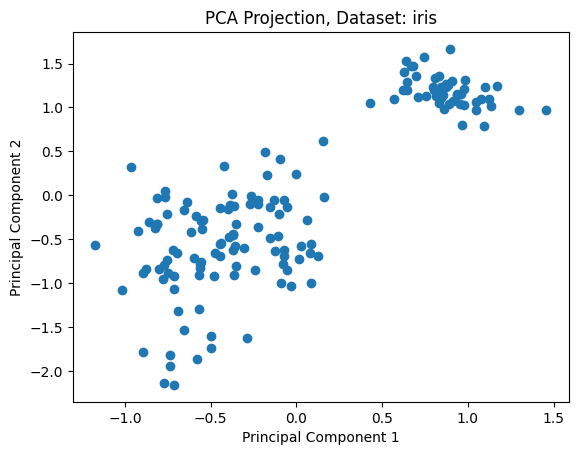

In [ ]:
name = 'iris'
print("Датасет: " + name)
title = "PCA Projection, Dataset: " + name
x_proj, ratio = apply_pca_to_dataset(name, 2, False, 1e-10)
print(f"Проекция данных (первые 5 строк):\n{x_proj.submatrix(0, 0, 5, 2)}")
print(f"Доля объяснённой дисперсии: {ratio:.4f}")

fig = plot_pca_projection(x_proj, title)
plt.show()
print()

Датасет: wine
Проекция данных (первые 5 строк):
318.5629792879366 -21.49213073453993
303.0974196593864 5.364717683064033
438.06113291723625 6.537309449440171
733.2401393508117 -0.1927290320719539
-11.571428495905657 -18.48999460836035
Доля объяснённой дисперсии: 0.9998


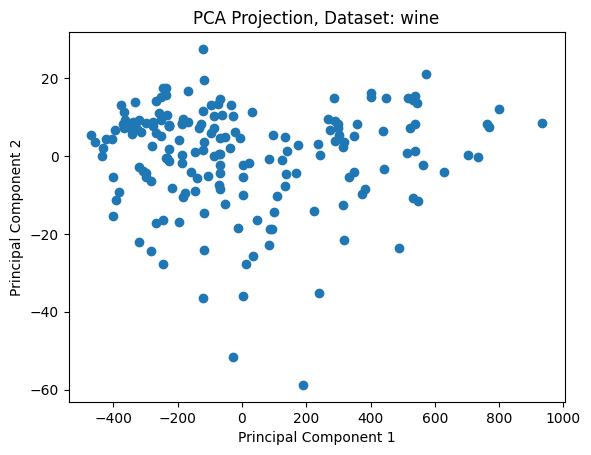

In [ ]:
name = 'wine'
print("Датасет: " + name)
title = "PCA Projection, Dataset: " + name
x_proj, ratio = apply_pca_to_dataset(name, 2, useQR=True, eps=1e-6)
print(f"Проекция данных (первые 5 строк):\n{x_proj.submatrix(0, 0, 5, 2)}")
print(f"Доля объяснённой дисперсии: {ratio:.4f}")
fig = plot_pca_projection(x_proj, title)
plt.show()
print()

Датасет: breast_cancer
Проекция данных (первые 5 строк):
-0.5893594891669042 -0.3078043381310119
0.08403471884788836 0.0806420067127402
0.18699350829248895 0.27917351007879215
0.14415507351301596 0.9274705201019722
0.13850191139382098 0.042228103067086215
Доля объяснённой дисперсии: 0.9982


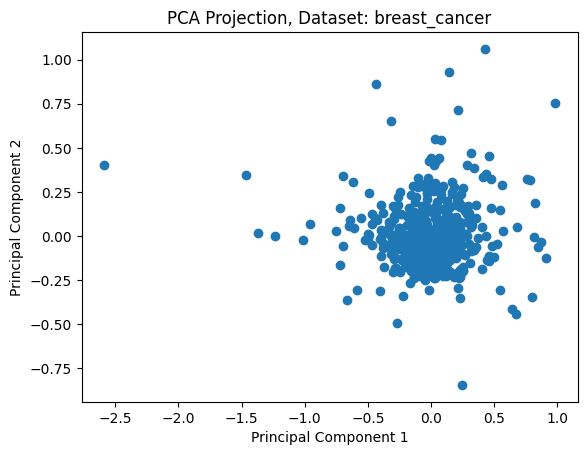

In [ ]:
name = 'breast_cancer'
print("Датасет: " + name)
title = "PCA Projection, Dataset: " + name
x_proj, ratio = apply_pca_to_dataset(name, 2, useQR = True)
print(f"Проекция данных (первые 5 строк):\n{x_proj.submatrix(0, 0, 5, 2)}")
print(f"Доля объяснённой дисперсии: {ratio:.4f}")

fig = plot_pca_projection(x_proj, title)
plt.show()
print()

Юнит тесты:

In [ ]:
import unittest
import numpy as np # для перепроверки

class TestMatrixOperations(unittest.TestCase):
    def test_matrix_creation(self):
        data = [[1, 2], [3, 4]]
        m = Matrix(data)
        self.assertEqual(m.rows, 2)
        self.assertEqual(m.cols, 2)
        self.assertEqual(m.data, data)

    def test_matrix_addition(self):
        A = Matrix([[1, 2], [3, 4]])
        B = Matrix([[5, 6], [7, 8]])
        result = A + B
        expected = Matrix([[6, 8], [10, 12]])
        np.testing.assert_array_equal(np.array(result.data), np.array(expected.data))

    def test_matrix_multiplication(self):
        A = Matrix([[1, 2], [3, 4]])
        B = Matrix([[2, 0], [0, 2]])
        result = A * B
        expected = Matrix([[2, 0], [0, 8]])
        np.testing.assert_array_equal(np.array(result.data), np.array(expected.data))

    def test_matrix_transpose(self):
        A = Matrix([[1, 2], [3, 4], [5, 6]])
        At = A.transpose()
        expected = Matrix([[1, 3, 5], [2, 4, 6]])
        np.testing.assert_array_equal(np.array(At.data), np.array(expected.data))

    def test_determinant(self):
        A = Matrix([[1, 2], [3, 4]])
        self.assertAlmostEqual(A.calculate_determinant(), -2, delta=1e-6)

class TestEigenDecomposition(unittest.TestCase):
    def test_eigenvectors(self):
        eigenvalues = qr_algorithm(self.test_matrix)
        eigenvectors = get_eigenvectors(self.test_matrix, eigenvalues)

        for i, vec in enumerate(eigenvectors):
            v = np.array(vec.data).flatten()
            Av = np.dot(self.np_matrix, v)
            λv = eigenvalues[i] * v
            np.testing.assert_allclose(Av, λv, atol=1e-4)
    def setUp(self):
        self.test_matrix = Matrix([[4, 1, 2], [1, 3, 5], [2, 5, 6]])
        self.np_matrix = np.array(self.test_matrix.data, dtype=np.float64)

    def test_eigenvalues_bisection(self):
        eigenvalues = get_eigenvalues(self.test_matrix)
        np_eigenvalues = np.linalg.eigvals(self.np_matrix)
        np.testing.assert_allclose(sorted(eigenvalues), sorted(np_eigenvalues), atol=1e-6)

    def test_eigenvalues_qr(self):
        eigenvalues = qr_algorithm(self.test_matrix)
        np_eigenvalues = np.linalg.eigvals(self.np_matrix)
        np.testing.assert_allclose(sorted(eigenvalues), sorted(np_eigenvalues), atol=1e-6)


class TestPCA(unittest.TestCase):
    def setUp(self):
        self.data = Matrix([
            [2.5, 2.4],
            [0.5, 0.7],
            [2.2, 2.9],
            [1.9, 2.2],
            [3.1, 3.0],
            [2.3, 2.7],
            [2, 1.6],
            [1, 1.1],
            [1.5, 1.6],
            [1.1, 0.9]
        ])

    def test_centering(self):
        centered = center_data(self.data)
        np_data = np.array(self.data.data)
        np_centered = np_data - np.mean(np_data, axis=0)
        np.testing.assert_allclose(np.array(centered.data), np_centered, atol=1e-6)

    def test_covariance_matrix(self):
        centered = center_data(self.data)
        C = covariance_matrix(centered)
        np_cov = np.cov(np.array(centered.data).T, bias=False)
        np.testing.assert_allclose(np.array(C.data), np_cov, atol=1e-6)

    def test_pca_projection(self):
        x_proj, ratio = pca(self.data, 1)
        self.assertEqual(x_proj.cols, 1)
        self.assertAlmostEqual(ratio, 0.963, delta=0.01)


class TestQRDecomposition(unittest.TestCase):
    def test_qr_decomposition(self):
        A = Matrix([[12, -51, 4], [6, 167, -68], [-4, 24, -41]])
        Q, R = qr_decomposition(A)
        # Проверка ортогональности Q
        QTQ = Q.transpose() @ Q
        np.testing.assert_allclose(np.array(QTQ.data), np.eye(3), atol=1e-6)
        # Проверка восстановления матрицы
        A_reconstructed = Q @ R
        np.testing.assert_allclose(np.array(A_reconstructed.data), np.array(A.data), atol=1e-6)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

............
----------------------------------------------------------------------
Ran 12 tests in 0.028s

OK
